# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import asarray
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Import Dataset

In [2]:
df = pd.read_csv("CO2 emissions.csv")

In [3]:
df.head()

,Year,Metric Tons Per Capita
0,31-12-1990,3.8963
1,31-12-1991,3.8581
2,31-12-1992,3.8018
3,31-12-1993,3.7679
4,31-12-1994,3.7314


In [4]:
df['Year'] = pd.to_datetime(df['Year'], format='%d-%m-%Y')
df['Year'] = df['Year'].dt.year

In [ ]:
df.tail()

,Year,Metric Tons Per Capita
25,2015,4.4559
26,2016,4.4072
27,2017,4.4225
28,2018,4.4754
29,2019,4.4357


In [ ]:
df.describe()

,Year,Metric Tons Per Capita
count,30.000000,30.000000
mean,2004.500000,4.126067
std,8.803408,0.314599
min,1990.000000,3.731400
25%,1997.250000,3.814975
50%,2004.500000,4.134500
75%,2011.750000,4.432400
max,2019.000000,4.581300


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     30 non-null     int64  
 1    Metric Tons Per Capita  30 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 608.0 bytes


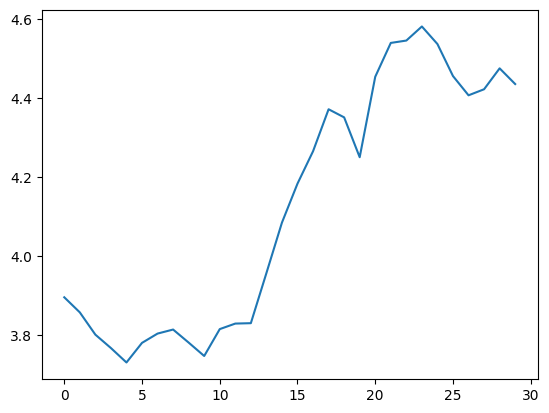

In [ ]:
timeseries = df[[" Metric Tons Per Capita"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

# LSTM

In [ ]:
# train-test split for time series
train_size = int(len(timeseries) * 0.69)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [ ]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [ ]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([19, 1, 1]) torch.Size([19, 1, 1])
torch.Size([9, 1, 1]) torch.Size([9, 1, 1])


In [ ]:
class Emissions_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [ ]:
model = Emissions_Model()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 3.7599, test RMSE 4.2902
Epoch 100: train RMSE 0.1160, test RMSE 0.2451
Epoch 200: train RMSE 0.1149, test RMSE 0.2350
Epoch 300: train RMSE 0.1130, test RMSE 0.2296
Epoch 400: train RMSE 0.1106, test RMSE 0.2268
Epoch 500: train RMSE 0.1078, test RMSE 0.2205
Epoch 600: train RMSE 0.1047, test RMSE 0.2163
Epoch 700: train RMSE 0.1005, test RMSE 0.1914
Epoch 800: train RMSE 0.0969, test RMSE 0.1667
Epoch 900: train RMSE 0.0915, test RMSE 0.1566
Epoch 1000: train RMSE 0.0868, test RMSE 0.1518
Epoch 1100: train RMSE 0.0813, test RMSE 0.1198
Epoch 1200: train RMSE 0.0768, test RMSE 0.1079
Epoch 1300: train RMSE 0.0727, test RMSE 0.0840
Epoch 1400: train RMSE 0.0697, test RMSE 0.0696
Epoch 1500: train RMSE 0.0677, test RMSE 0.0618
Epoch 1600: train RMSE 0.0678, test RMSE 0.0595
Epoch 1700: train RMSE 0.0660, test RMSE 0.0524
Epoch 1800: train RMSE 0.0668, test RMSE 0.0524
Epoch 1900: train RMSE 0.0662, test RMSE 0.0537
Epoch 2000: train RMSE 0.0649, test RMSE 0.0519
Epoc

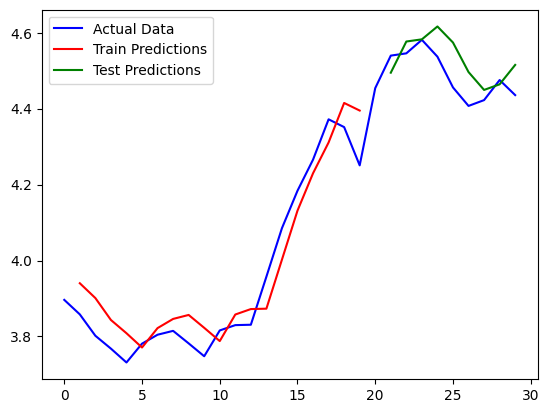

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b',label="Actual Data")
plt.plot(train_plot, c='r',label = "Train Predictions")
plt.plot(test_plot, c='g',label = "Test Predictions")
plt.legend()
plt.show()

In [ ]:
train_plot

array([[      nan],
       [3.9401252],
       [3.9010892],
       [3.8433497],
       [3.808469 ],
       [3.7708209],
       [3.8219576],
       [3.8461246],
       [3.856601 ],
       [3.8226783],
       [3.7877483],
       [3.8577302],
       [3.8720958],
       [3.8731217],
       [4.0023136],
       [4.1313367],
       [4.229835 ],
       [4.310909 ],
       [4.4149804],
       [4.3949876],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan]], dtype=float32)

In [ ]:
test_plot

array([[      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [      nan],
       [4.494676 ],
       [4.576839 ],
       [4.5825663],
       [4.6164556],
       [4.574166 ],
       [4.496413 ],
       [4.449299 ],
       [4.46413  ],
       [4.515201 ]], dtype=float32)

In [ ]:
train_plot = train_plot.flatten()
test_plot = test_plot.flatten()

# Ignore null values and merge the arrays
predictions_values = np.concatenate((train_plot[~np.isnan(train_plot)], test_plot[~np.isnan(test_plot)]))

# Create a DataFrame
predictions = pd.DataFrame({'Predictions': predictions_values})

predictions.head(5)

,Predictions
0,3.940125
1,3.901089
2,3.843350
3,3.808469
4,3.770821


In [ ]:
train

array([[3.8963],
       [3.8581],
       [3.8018],
       [3.7679],
       [3.7314],
       [3.781 ],
       [3.8045],
       [3.8147],
       [3.7817],
       [3.7478],
       [3.8158],
       [3.8298],
       [3.8308],
       [3.9574],
       [4.0852],
       [4.1838],
       [4.2657],
       [4.3719],
       [4.3514],
       [4.2506]], dtype=float32)

In [ ]:
test

array([[4.4541],
       [4.5397],
       [4.5457],
       [4.5813],
       [4.5369],
       [4.4559],
       [4.4072],
       [4.4225],
       [4.4754],
       [4.4357]], dtype=float32)

In [ ]:
train = train.flatten()
test = test.flatten()

actual_train_values = train[1:]
actual_train = pd.DataFrame({'Actual': actual_train_values})

actual_test_values = test[1:]
actual_test = pd.DataFrame({'Actual': actual_test_values})

actual = pd.concat([actual_train, actual_test], ignore_index=True)


In [ ]:
actual.head()

,Actual
0,3.8581
1,3.8018
2,3.7679
3,3.7314
4,3.7810


In [ ]:
result = pd.concat([actual, predictions], axis=1)

In [ ]:
result.head()

,Actual,Predictions
0,3.8581,3.940125
1,3.8018,3.901089
2,3.7679,3.843350
3,3.7314,3.808469
4,3.7810,3.770821


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Calculate MSE
mse_lstm = mean_squared_error(result['Actual'], result['Predictions'])

# Calculate RMSE
rmse_lstm=sqrt(mean_squared_error(result['Actual'],result['Predictions']))

# Calculate MAE
mae_lstm = mean_absolute_error(result['Actual'], result['Predictions'])

# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_lstm = calculate_mape(result['Actual'], result['Predictions'])

# Calculate R2 score
r2_lstm = r2_score(result['Actual'], result['Predictions'])

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.5f}")


MSE: 0.004613025579601526
RMSE: 0.06791925779630933
MAE: 0.05880134552717209
MAPE: 1.43%
R2 Score: 0.95233


# XGBoost Regressor

In [ ]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols = list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
        # put it all together
        agg = concat(cols, axis=1)
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg.values

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
        return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
        # transform list into array
        train = asarray(train)
        # split into input and output columns
        trainX, trainy = train[:, :-1], train[:, -1]
        # fit model
        model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
        model.fit(trainX, trainy)
        # make a one-step prediction
        yhat = model.predict(asarray([testX]))
        return yhat[0]


In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
        predictions = list()
        # split dataset
        train, test = train_test_split(data, n_test)
        # seed history with training dataset
        history = [x for x in train]
        # step over each time-step in the test set
        for i in range(len(test)):
            # split test row into input and output columns
            testX, testy = test[i, :-1], test[i, -1]
            # fit model on history and make a prediction
            yhat = xgboost_forecast(history, testX)
            # store forecast in list of predictions
            predictions.append(yhat)
            # add actual observation to history for the next loop
            history.append(test[i])
            # summarize progress
            print('>expected=%.5f, predicted=%.5f' % (testy, yhat))
        # estimate prediction error
        error = mean_absolute_error(test[:, -1], predictions)
        return error, test[:, -1], predictions

>expected=4.25060, predicted=4.35174
>expected=4.45410, predicted=4.25101
>expected=4.53970, predicted=4.45163
>expected=4.54570, predicted=4.45634
>expected=4.58130, predicted=4.54290
>expected=4.53690, predicted=4.58001
>expected=4.45590, predicted=4.54533
>expected=4.40720, predicted=4.51068
>expected=4.42250, predicted=4.40755
>expected=4.47540, predicted=4.42200
>expected=4.43570, predicted=4.46838
MAE: 0.078


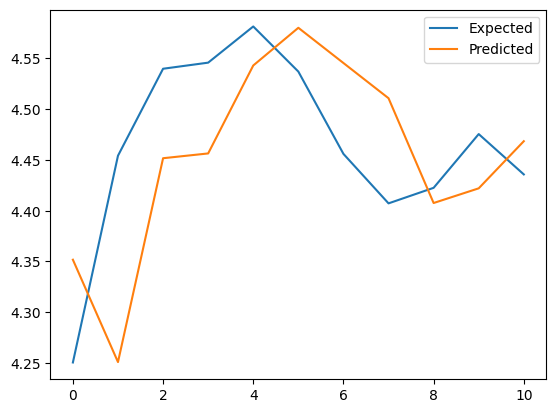

In [ ]:
# load the dataset
series = read_csv('CO2 Emissions.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 11)
print('MAE: %.3f' % mae)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [ ]:
mse_xg = mean_squared_error(y, yhat)

rmse_xg = np.sqrt(mse)

r2_xg = r2_score(y, yhat)

mape_xg = mean_absolute_percentage_error(y, yhat)

print(f'Mean Squared Error (MSE): {mse_xg:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_xg:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape_xg:.4f}')
print(f'R-squared (R2) Score: {r2_xg:.4f}')

Mean Squared Error (MSE): 0.0085
Root Mean Squared Error (RMSE): 0.2413
Mean Absolute Percentage Error (MAPE): 0.0175
R-squared (R2) Score: -0.1245


# FB Prophet

In [5]:
emission_df = pd.read_csv('CO2 emissions.csv' , index_col='Year', parse_dates=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9836\2874175866.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  emission_df = pd.read_csv('CO2 emissions.csv' , index_col='Year', parse_dates=True)


In [ ]:
emission_df.head()

,Metric Tons Per Capita
Year,
1990-12-31,3.8963
1991-12-31,3.8581
1992-12-31,3.8018
1993-12-31,3.7679
1994-12-31,3.7314


In [6]:
fb_df = emission_df.reset_index()
fb_df.head()

,Year,Metric Tons Per Capita
0,1990-12-31,3.8963
1,1991-12-31,3.8581
2,1992-12-31,3.8018
3,1993-12-31,3.7679
4,1994-12-31,3.7314


In [7]:
fb_df= fb_df.rename(columns={'Year':'ds', ' Metric Tons Per Capita':'y'})
fb_df.head()

,ds,y
0,1990-12-31,3.8963
1,1991-12-31,3.8581
2,1992-12-31,3.8018
3,1993-12-31,3.7679
4,1994-12-31,3.7314


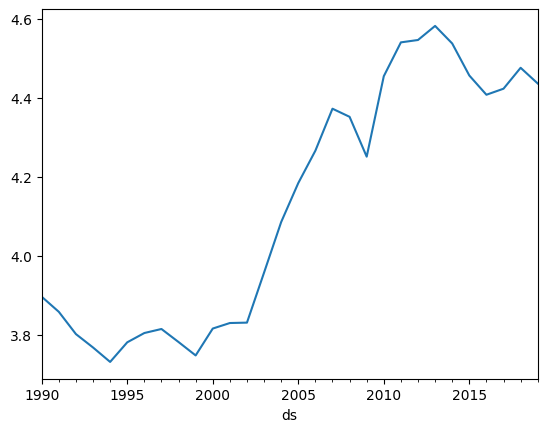

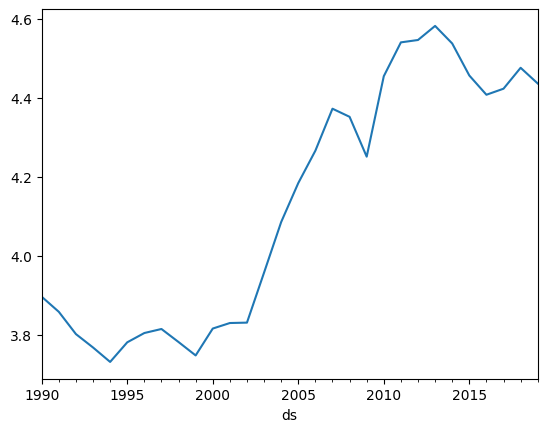

In [ ]:
fb_df.set_index('ds').y.plot().get_figure()

In [8]:
model = Prophet(yearly_seasonality=True)
model.fit(fb_df);
model.yearly_seasonality

23:43:23 - cmdstanpy - INFO - Chain [1] start processing
23:43:23 - cmdstanpy - INFO - Chain [1] done processing


True

In [17]:
future = model.make_future_dataframe(periods=11, freq = 'y')
future.tail()

,ds
36,2026-12-31
37,2027-12-31
38,2028-12-31
39,2029-12-31
40,2030-12-31


In [18]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
36,2026-12-31,1.066191,4.208824,4.459792,0.951083,1.168341,3.270659,3.270659,3.270659,3.270659,3.270659,3.270659,0.0,0.0,0.0,4.336850
37,2027-12-31,1.052411,4.184547,4.480940,0.911669,1.177415,3.283182,3.283182,3.283182,3.283182,3.283182,3.283182,0.0,0.0,0.0,4.335593
38,2028-12-31,1.038594,4.126442,4.462626,0.868611,1.188620,3.267235,3.267235,3.267235,3.267235,3.267235,3.267235,0.0,0.0,0.0,4.305829
39,2029-12-31,1.024814,4.077169,4.479514,0.824304,1.202262,3.265332,3.265332,3.265332,3.265332,3.265332,3.265332,0.0,0.0,0.0,4.290145
40,2030-12-31,1.011034,4.038280,4.492337,0.779903,1.216445,3.270659,3.270659,3.270659,3.270659,3.270659,3.270659,0.0,0.0,0.0,4.281693


# FB Prophet Forecasting

In [19]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
31,2021-12-31,4.400460,4.334134,4.467672
32,2022-12-31,4.392008,4.313135,4.459728
33,2023-12-31,4.390751,4.307658,4.471859
34,2024-12-31,4.360986,4.262089,4.448518
35,2025-12-31,4.345303,4.230756,4.451474
36,2026-12-31,4.336850,4.208824,4.459792
37,2027-12-31,4.335593,4.184547,4.480940
38,2028-12-31,4.305829,4.126442,4.462626
39,2029-12-31,4.290145,4.077169,4.479514
40,2030-12-31,4.281693,4.038280,4.492337


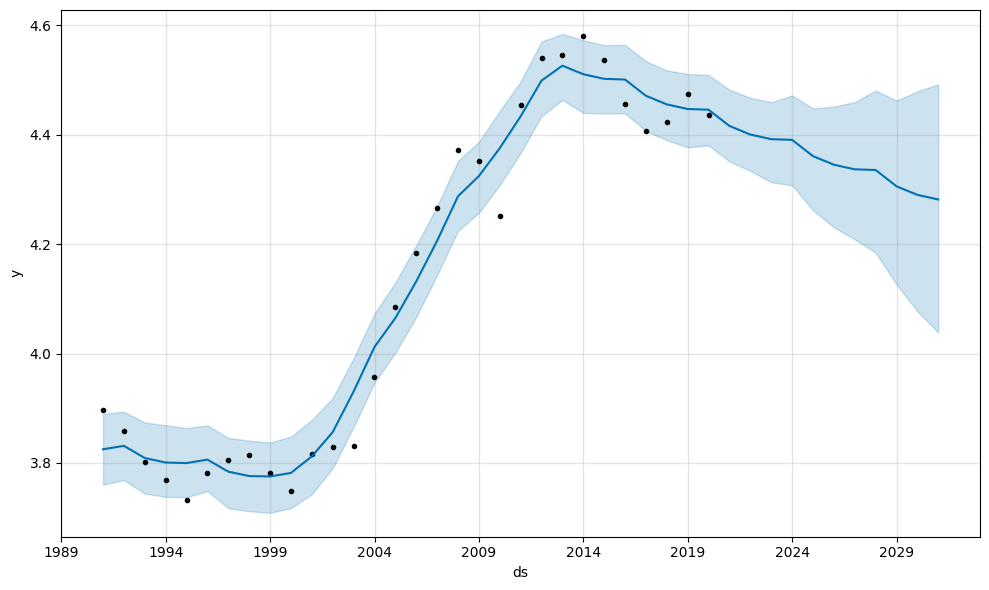

In [20]:
model.plot(forecast);

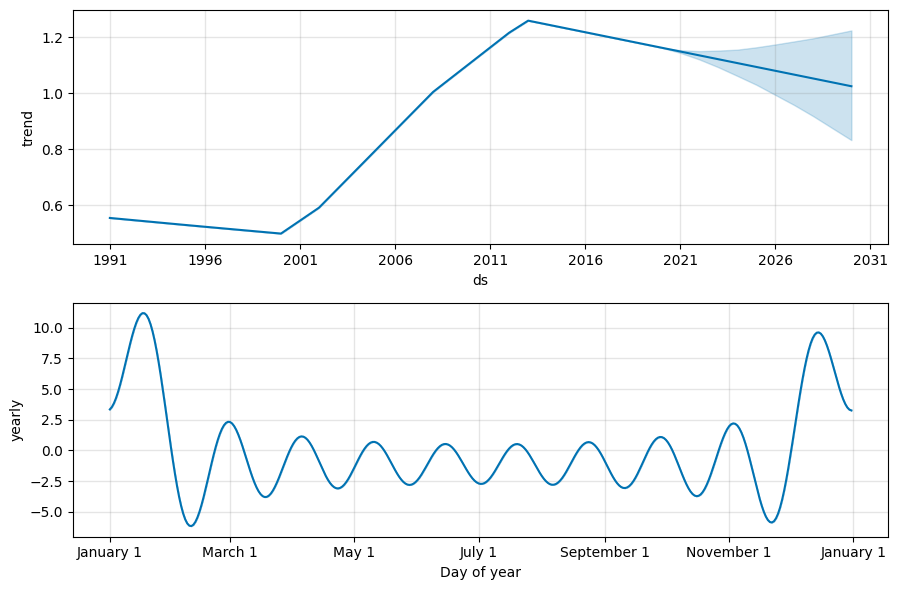

In [ ]:
model.plot_components(forecast);

In [13]:
metric_df = forecast.set_index('ds')[['yhat']].join(fb_df.set_index('ds').y).reset_index()

In [14]:
metric_df.tail()

,ds,yhat,y
35,2025-12-31,4.345303,NaN
36,2026-12-31,4.336850,NaN
37,2027-12-31,4.335593,NaN
38,2028-12-31,4.305829,NaN
39,2029-12-31,4.290145,NaN


In [15]:
metric_df.dropna(inplace=True)

In [16]:
metric_df.tail()

,ds,yhat,y
25,2015-12-31,4.501066,4.4559
26,2016-12-31,4.471302,4.4072
27,2017-12-31,4.455618,4.4225
28,2018-12-31,4.447165,4.4754
29,2019-12-31,4.445908,4.4357


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate MSE
mse_fb = mean_squared_error(metric_df.y, metric_df.yhat)

# Calculate RMSE
rmse_fb = np.sqrt(mean_squared_error(metric_df.y, metric_df.yhat))

# Calculate MAE
mae_fb = mean_absolute_error(metric_df.y, metric_df.yhat)

# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_fb = calculate_mape(metric_df.y, metric_df.yhat)

# Calculate R2 score
r2_fb = r2_score(metric_df.y, metric_df.yhat)

# Print the metrics
print(f"MSE: {mse_fb:.4f}")
print(f"RMSE: {rmse_fb:.4f}")
print(f"MAE: {mae_fb:.4f}")
print(f"MAPE: {mape_fb:.4f}%")
print(f"R-squared (R2) Score: {r2_fb:.4f}")

MSE: 0.0025
RMSE: 0.0503
MAE: 0.0417
MAPE: 1.0085%
R-squared (R2) Score: 0.9736


# Comparing all 3 models

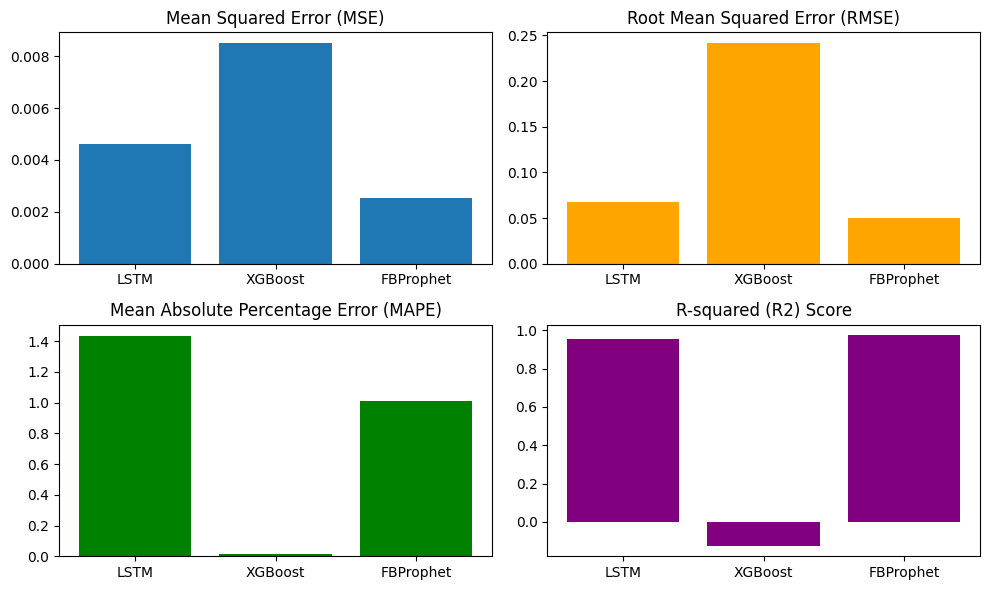

In [ ]:
mse_values = [mse_lstm, mse_xg, mse_fb]
rmse_values = [rmse_lstm, rmse_xg, rmse_fb]
mape_values = [mape_lstm, mape_xg, mape_fb]
r2_values = [r2_lstm, r2_xg, r2_fb]
models = ['LSTM', 'XGBoost', 'FBProphet']

# Plot the metrics for each model
plt.figure(figsize=(10, 6))

# MSE plot
plt.subplot(2, 2, 1)
plt.bar(models, mse_values)
plt.title('Mean Squared Error (MSE)')

# RMSE plot
plt.subplot(2, 2, 2)
plt.bar(models, rmse_values, color='orange')
plt.title('Root Mean Squared Error (RMSE)')

# MAPE plot
plt.subplot(2, 2, 3)
plt.bar(models, mape_values, color='green')
plt.title('Mean Absolute Percentage Error (MAPE)')

# R2 plot
plt.subplot(2, 2, 4)
plt.bar(models, r2_values, color='purple')
plt.title('R-squared (R2) Score')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Define the metric values for each model
models = ['LSTM', 'XGBoost', 'FBProphet']
metrics = ['MSE', 'RMSE', 'MAPE', 'R2']
values = [
    [mse_lstm, rmse_lstm, mape_lstm, r2_lstm],
    [mse_xg, rmse_xg, mape_xg, r2_xg],
    [mse_fb, rmse_fb, mape_fb, r2_fb]
]

# Create a DataFrame to store the metric values
metric_table = pd.DataFrame(values, columns=metrics, index=models)

metric_table


,MSE,RMSE,MAPE,R2
LSTM,0.004613,0.067919,1.434688,0.952328
XGBoost,0.008491,0.241289,0.017506,-0.124471
FBProphet,0.002527,0.050272,1.008453,0.973585
